In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

data_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'


mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 512
NUM_IMAGES = 64



## Functions to load images

In [3]:
def load_dicom_image(path, img_size=SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train", rotate=0):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

a = load_dicom_images_3d("00000")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))

(1, 512, 512, 64)
0.0 1.0 0.07787377691897238 0.00023327922127467515


In [4]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(12)

## train / test splits

In [5]:
train_df = pd.read_csv(f"{data_directory}/train_labels.csv")
display(train_df)
rem = [109, 123, 709]
train_df = train_df[~train_df.BraTS21ID.isin(rem)].reset_index(drop = True)
df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=0.1, 
    random_state=12, 
    stratify=train_df["MGMT_value"],
)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [6]:
df_train.tail()

,BraTS21ID,MGMT_value
104,158,0
357,529,1
114,172,0
466,682,0
80,124,0


## Model and training classes

In [7]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, label_smoothing=0.01, split="train", augment=False):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.label_smoothing = label_smoothing
        self.split = split
        self.augment = augment
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split)
        else:
            if self.augment:
                rotation = np.random.randint(0,4)
            else:
                rotation = 0

            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train", rotate=rotation)

        if self.targets is None:
            return {"X": torch.tensor(data).float(), "id": scan_id}
        else:
            y = torch.tensor(abs(self.targets[index]-self.label_smoothing), dtype=torch.float)
            return {"X": torch.tensor(data).float(), "y": y}


In [8]:
!pip install ../input/einops-030/einops-0.3.0-py2.py3-none-any.whl

Processing /kaggle/input/einops-030/einops-0.3.0-py2.py3-none-any.whl


In [9]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        mlp_dim = 2048
        for _ in range(depth):
            #print (dim, mlp_dim)
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x



### Vit Model change to 3D

reference:
https://github.com/lucidrains/vit-pytorch

In [10]:
class Model(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) *(image_size // patch_size)* 2
        patch_dim = channels * patch_size ** 3

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        #print (mlp_dim)
        self.transformer = Transformer(dim, depth, heads, mlp_dim, dropout)
        #print (dim)
        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, num_classes),
            nn.Dropout(dropout)
        )

    def forward(self, img, mask = None):
        p = self.patch_size
        #print (img.shape)
        x = rearrange(img, 'b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1 = p, p2 = p, p3 = p)
        #print (x.shape)
        x = self.patch_to_embedding(x)
        #print (x.shape)
        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        #print (cls_tokens.shape)
        x = torch.cat((cls_tokens, x), dim=1)
        #print (x.shape)
        #print (self.pos_embedding.shape)
        x += self.pos_embedding
        x = self.dropout(x)

        x = self.transformer(x)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

In [12]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion

        self.best_valid_score = np.inf
        self.n_patience = 0
        self.lastmodel = None
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):        
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_time = self.train_epoch(train_loader)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s            ",
                n_epoch, train_loss, train_time
            )
            
            self.info_message(
                "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
                n_epoch, valid_loss, valid_auc, valid_time
            )

            # if True:
            #if self.best_valid_score < valid_auc: 
            if self.best_valid_score > valid_loss: 
                self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                self.info_message(
                     "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                    self.best_valid_score, valid_loss, self.lastmodel
                )
                self.best_valid_score = valid_loss
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0

        for step, batch in enumerate(train_loader, 1):
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            sum_loss += loss.detach().item()

            self.optimizer.step()
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)

                sum_loss += loss.detach().item()
                y_all.extend(batch["y"].tolist())
                outputs_all.extend(torch.sigmoid(outputs).tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        y_all = [1 if x > 0.5 else 0 for x in y_all]
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = f"{save_path}-best.pth"
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

## train models

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_mri_type(df_train, df_valid, mri_type):
    if mri_type=="all":
        train_list = []
        valid_list = []
        for mri_type in mri_types:
            df_train.loc[:,"MRI_Type"] = mri_type
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri_type
            valid_list.append(df_valid.copy())

        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
    else:
        df_train.loc[:,"MRI_Type"] = mri_type
        df_valid.loc[:,"MRI_Type"] = mri_type

    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    
    train_data_retriever = Dataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values,
        augment=True
    )

    valid_data_retriever = Dataset(
        df_valid["BraTS21ID"].values, 
        df_valid["MGMT_value"].values,
        df_valid["MRI_Type"].values
    )

    train_loader = torch_data.DataLoader(
        train_data_retriever,
        batch_size=4,
        shuffle=True,
        num_workers=8,pin_memory = True
    )

    valid_loader = torch_data.DataLoader(
        valid_data_retriever, 
        batch_size=4,
        shuffle=False,
        num_workers=8,pin_memory = True
    )

    model = Model(
        image_size = 512,
        patch_size = 32,
        num_classes = 1,
        dim = 1024,
        depth = 2,
        heads = 16,
        mlp_dim = 2048,
        channels = 1,
        dropout = 0.1,
        emb_dropout = 0.1
    )
    model.to(device)


    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    criterion = torch_functional.binary_cross_entropy_with_logits

    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        10, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        10,
    )
    
    return trainer.lastmodel

modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in mri_types]
    print(modelfiles)

(523, 3) (59, 3)


,BraTS21ID,MGMT_value,MRI_Type
3,5,1,FLAIR
473,690,1,FLAIR
116,177,1,FLAIR
365,542,1,FLAIR
450,654,0,FLAIR


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


EPOCH: 1
[Epoch Train: 1] loss: 0.8510, time: 236.00 s            
[Epoch Valid: 1] loss: 0.6946, auc: 0.7085, time: 29.00 s
auc improved from inf to 0.6946. Saved model to 'FLAIR-best.pth'
EPOCH: 2


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 2] loss: 0.6962, time: 242.00 s            
[Epoch Valid: 2] loss: 0.6770, auc: 0.7339, time: 28.00 s
auc improved from 0.6946 to 0.6770. Saved model to 'FLAIR-best.pth'
EPOCH: 3


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 3] loss: 0.7034, time: 239.00 s            
[Epoch Valid: 3] loss: 0.6814, auc: 0.7154, time: 28.00 s
EPOCH: 4


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 4] loss: 0.6963, time: 235.00 s            
[Epoch Valid: 4] loss: 0.6859, auc: 0.7465, time: 27.00 s
EPOCH: 5


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 5] loss: 0.6928, time: 236.00 s            
[Epoch Valid: 5] loss: 0.6857, auc: 0.7039, time: 27.00 s
EPOCH: 6


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 6] loss: 0.6926, time: 236.00 s            
[Epoch Valid: 6] loss: 0.6965, auc: 0.7892, time: 27.00 s
EPOCH: 7


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 7] loss: 0.6930, time: 236.00 s            
[Epoch Valid: 7] loss: 0.7113, auc: 0.6809, time: 27.00 s
EPOCH: 8


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 8] loss: 0.8342, time: 236.00 s            
[Epoch Valid: 8] loss: 0.7059, auc: 0.4182, time: 27.00 s
EPOCH: 9


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 9] loss: 0.7622, time: 235.00 s            
[Epoch Valid: 9] loss: 0.6817, auc: 0.7074, time: 27.00 s
EPOCH: 10


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 10] loss: 0.6957, time: 237.00 s            
[Epoch Valid: 10] loss: 0.6906, auc: 0.6728, time: 28.00 s
(523, 3) (59, 3)


,BraTS21ID,MGMT_value,MRI_Type
3,5,1,T1w
473,690,1,T1w
116,177,1,T1w
365,542,1,T1w
450,654,0,T1w


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


EPOCH: 1
[Epoch Train: 1] loss: 0.8509, time: 243.00 s            
[Epoch Valid: 1] loss: 0.6903, auc: 0.5415, time: 29.00 s
auc improved from inf to 0.6903. Saved model to 'T1w-best.pth'
EPOCH: 2


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 2] loss: 0.7330, time: 245.00 s            
[Epoch Valid: 2] loss: 0.7104, auc: 0.6521, time: 29.00 s
EPOCH: 3


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 3] loss: 0.6948, time: 232.00 s            
[Epoch Valid: 3] loss: 0.6851, auc: 0.6313, time: 28.00 s
auc improved from 0.6903 to 0.6851. Saved model to 'T1w-best.pth'
EPOCH: 4


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 4] loss: 0.7027, time: 238.00 s            
[Epoch Valid: 4] loss: 0.6995, auc: 0.3975, time: 28.00 s
EPOCH: 5


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 5] loss: 0.6984, time: 233.00 s            
[Epoch Valid: 5] loss: 0.6899, auc: 0.6083, time: 29.00 s
EPOCH: 6


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 6] loss: 0.7851, time: 228.00 s            
[Epoch Valid: 6] loss: 0.7896, auc: 0.5726, time: 28.00 s
EPOCH: 7


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 7] loss: 0.7228, time: 228.00 s            
[Epoch Valid: 7] loss: 0.6909, auc: 0.5760, time: 28.00 s
EPOCH: 8


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 8] loss: 0.6937, time: 227.00 s            
[Epoch Valid: 8] loss: 0.6893, auc: 0.5956, time: 28.00 s
EPOCH: 9


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 9] loss: 0.6956, time: 227.00 s            
[Epoch Valid: 9] loss: 0.6865, auc: 0.6141, time: 28.00 s
EPOCH: 10


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 10] loss: 0.6944, time: 225.00 s            
[Epoch Valid: 10] loss: 0.6853, auc: 0.6060, time: 28.00 s
(523, 3) (59, 3)


,BraTS21ID,MGMT_value,MRI_Type
3,5,1,T1wCE
473,690,1,T1wCE
116,177,1,T1wCE
365,542,1,T1wCE
450,654,0,T1wCE


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


EPOCH: 1
[Epoch Train: 1] loss: 0.7918, time: 254.00 s            
[Epoch Valid: 1] loss: 0.6958, auc: 0.5161, time: 29.00 s
auc improved from inf to 0.6958. Saved model to 'T1wCE-best.pth'
EPOCH: 2


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 2] loss: 0.7078, time: 249.00 s            
[Epoch Valid: 2] loss: 0.6997, auc: 0.5380, time: 30.00 s
EPOCH: 3


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 3] loss: 0.6982, time: 235.00 s            
[Epoch Valid: 3] loss: 0.6930, auc: 0.6071, time: 28.00 s
auc improved from 0.6958 to 0.6930. Saved model to 'T1wCE-best.pth'
EPOCH: 4


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 4] loss: 0.6953, time: 242.00 s            
[Epoch Valid: 4] loss: 0.6934, auc: 0.4775, time: 29.00 s
EPOCH: 5


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 5] loss: 0.6961, time: 233.00 s            
[Epoch Valid: 5] loss: 0.6916, auc: 0.6210, time: 28.00 s
auc improved from 0.6930 to 0.6916. Saved model to 'T1wCE-best.pth'
EPOCH: 6


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 6] loss: 0.6945, time: 235.00 s            
[Epoch Valid: 6] loss: 0.6915, auc: 0.6083, time: 29.00 s
auc improved from 0.6916 to 0.6915. Saved model to 'T1wCE-best.pth'
EPOCH: 7


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 7] loss: 0.6932, time: 233.00 s            
[Epoch Valid: 7] loss: 0.6922, auc: 0.6037, time: 29.00 s
EPOCH: 8


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 8] loss: 0.6934, time: 231.00 s            
[Epoch Valid: 8] loss: 0.6916, auc: 0.5968, time: 28.00 s
EPOCH: 9


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 9] loss: 0.7105, time: 230.00 s            
[Epoch Valid: 9] loss: 0.6914, auc: 0.6267, time: 28.00 s
auc improved from 0.6915 to 0.6914. Saved model to 'T1wCE-best.pth'
EPOCH: 10


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 10] loss: 0.6958, time: 237.00 s            
[Epoch Valid: 10] loss: 0.6918, auc: 0.6233, time: 29.00 s
(523, 3) (59, 3)


,BraTS21ID,MGMT_value,MRI_Type
3,5,1,T2w
473,690,1,T2w
116,177,1,T2w
365,542,1,T2w
450,654,0,T2w


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


EPOCH: 1
[Epoch Train: 1] loss: 0.8037, time: 240.00 s            
[Epoch Valid: 1] loss: 0.6913, auc: 0.6446, time: 27.00 s
auc improved from inf to 0.6913. Saved model to 'T2w-best.pth'
EPOCH: 2


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 2] loss: 0.6984, time: 238.00 s            
[Epoch Valid: 2] loss: 0.6920, auc: 0.6705, time: 27.00 s
EPOCH: 3


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 3] loss: 0.6942, time: 231.00 s            
[Epoch Valid: 3] loss: 0.6920, auc: 0.6671, time: 27.00 s
EPOCH: 4


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 4] loss: 0.6947, time: 229.00 s            
[Epoch Valid: 4] loss: 0.6919, auc: 0.6768, time: 28.00 s
EPOCH: 5


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 5] loss: 0.6924, time: 227.00 s            
[Epoch Valid: 5] loss: 0.7035, auc: 0.6624, time: 26.00 s
EPOCH: 6


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 6] loss: 0.7167, time: 225.00 s            
[Epoch Valid: 6] loss: 0.6914, auc: 0.6279, time: 26.00 s
EPOCH: 7


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 7] loss: 0.6928, time: 221.00 s            
[Epoch Valid: 7] loss: 0.6913, auc: 0.6509, time: 27.00 s
auc improved from 0.6913 to 0.6913. Saved model to 'T2w-best.pth'
EPOCH: 8


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 8] loss: 0.6926, time: 230.00 s            
[Epoch Valid: 8] loss: 0.6913, auc: 0.6671, time: 26.00 s
EPOCH: 9


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 9] loss: 0.6921, time: 223.00 s            
[Epoch Valid: 9] loss: 0.6898, auc: 0.6544, time: 26.00 s
auc improved from 0.6913 to 0.6898. Saved model to 'T2w-best.pth'
EPOCH: 10


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 10] loss: 0.6990, time: 226.00 s            
[Epoch Valid: 10] loss: 0.6918, auc: 0.6947, time: 26.00 s
['FLAIR-best.pth', 'T1w-best.pth', 'T1wCE-best.pth', 'T2w-best.pth']


## Predict function

In [17]:
def predict(modelfile, df, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    df.loc[:,"MRI_Type"] = mri_type
    data_retriever = Dataset(
        df.index.values, 
        mri_type=df["MRI_Type"].values,
        split=split
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=4,
        shuffle=False,
        num_workers=8,
    )
   
    model = Model(
        image_size = 512,
        patch_size = 32,
        num_classes = 1,
        dim = 1024,
        depth = 2,
        heads = 16,
        mlp_dim = 2048,
        channels = 1,
  
    )
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch["X"].to(device))).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    preddf = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": y_pred}) 
    preddf = preddf.set_index("BraTS21ID")
    return preddf

## Ensemble for validation

Predict: FLAIR-best.pth FLAIR (59, 3)
Predict: T1w-best.pth T1w (59, 3)
Predict: T1wCE-best.pth T1wCE (59, 3)
Predict: T2w-best.pth T2w (59, 3)
Validation ensemble AUC: 0.7039


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


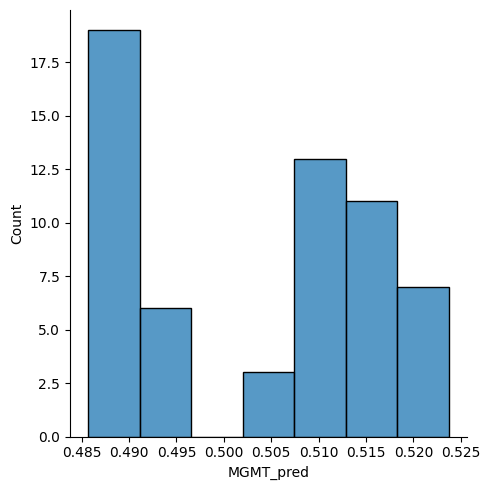

In [19]:
df_valid = df_valid.set_index("BraTS21ID")
df_valid["MGMT_pred"] = 0
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_valid, mtype, "train")
    df_valid["MGMT_pred"] += pred["MGMT_value"]
df_valid["MGMT_pred"] /= len(modelfiles)
auc = roc_auc_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_valid["MGMT_pred"])

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
df_valid["MGMT_pred_binary"] = (df_valid["MGMT_pred"] >= 0.5)
cm = confusion_matrix(df_valid["MGMT_value"], df_valid["MGMT_pred_binary"])

In [23]:
cm

array([[17, 11],
       [ 8, 23]])

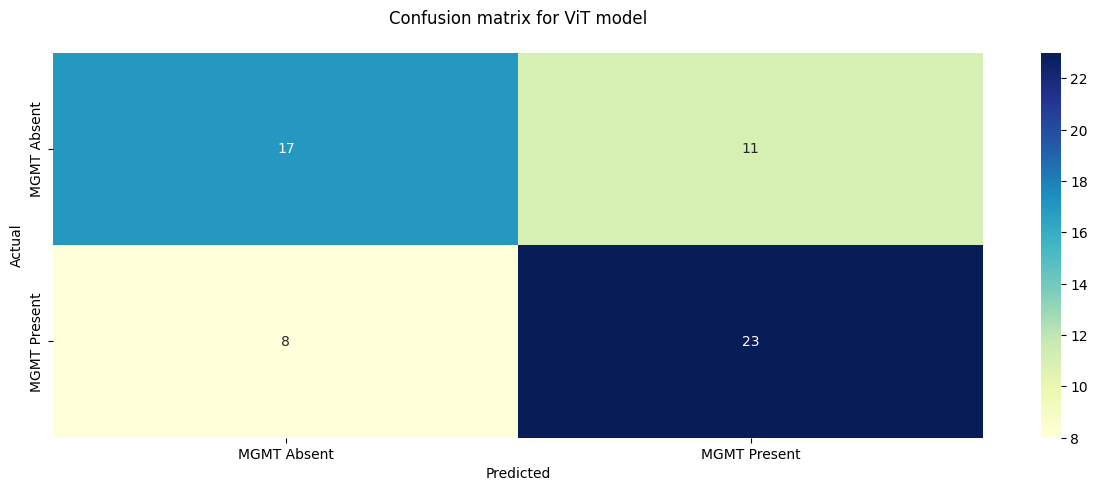

In [24]:
df_cm = pd.DataFrame(cm, index=['MGMT Absent', 'MGMT Present'], columns=['MGMT Absent', 'MGMT Present'])

plt.figure(figsize=(15, 5))

plt.title("Confusion matrix for ViT model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

In [25]:
binary_preds = df_valid["MGMT_pred_binary"]
labels = df_valid["MGMT_value"]
accuracy = accuracy_score(labels, binary_preds)
print(f"Model Accuracy Score: {accuracy}")

Model Accuracy Score: 0.6779661016949152


In [26]:
cr =classification_report(labels, binary_preds, target_names=['MGMT Absent', 'MGMT Present'])
print("Vit-512 Model Classification Report")
print("=========================================")
print(cr)

Vit-512 Model Classification Report
              precision    recall  f1-score   support

 MGMT Absent       0.68      0.61      0.64        28
MGMT Present       0.68      0.74      0.71        31

    accuracy                           0.68        59
   macro avg       0.68      0.67      0.67        59
weighted avg       0.68      0.68      0.68        59



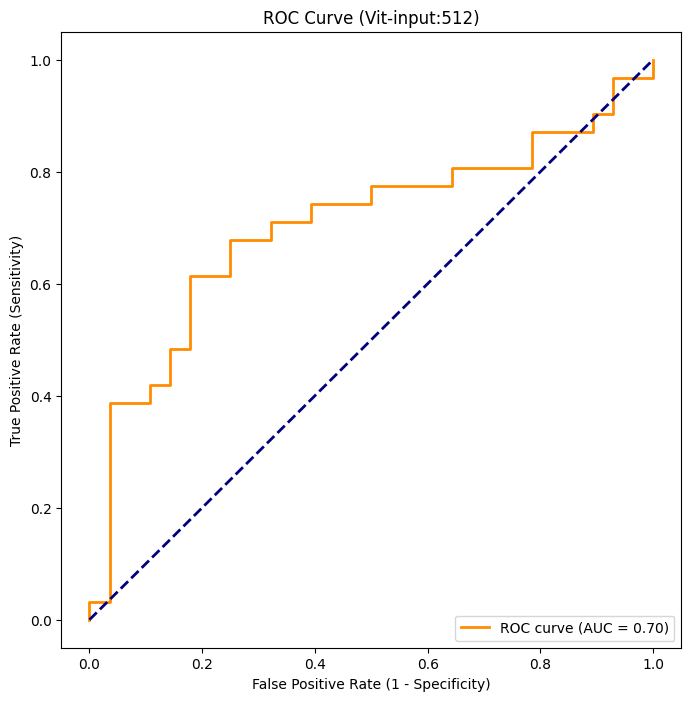

In [29]:
fpr, tpr, thresholds = roc_curve(labels, df_valid["MGMT_pred"])

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve (Vit-input:512)')
plt.legend(loc='lower right')
plt.show()

In [30]:
print("ViT-size:512 Model")
print("=========================================")
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print(f'MGMT Present : Sensitivity = {sensitivity}, Specificity = {specificity}')

ViT-size:512 Model
MGMT Present : Sensitivity = 0.7419354838709677, Specificity = 0.6071428571428571


## Ensemble for submission

In [ ]:
submission = pd.read_csv(f"{data_directory}/sample_submission.csv", index_col="BraTS21ID")

submission["MGMT_value"] = 0
for m, mtype in zip(modelfiles, mri_types):
    pred = predict(m, submission, mtype, split="test")
    submission["MGMT_value"] += pred["MGMT_value"]

submission["MGMT_value"] /= len(modelfiles)
submission["MGMT_value"].to_csv("submission.csv")

In [ ]:
submission

In [ ]:
sns.displot(submission["MGMT_value"])

Refernece:

- https://www.kaggle.com/rluethy/efficientnet3d-with-one-mri-type
- https://github.com/lucidrains/vit-pytorch


#### Many thanks to @ROLAND LUETHY and to @[MUEN]funkyboy
